The aim of this notebook is to auto segment the carries using k-mean clustering

In [185]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
import seaborn as sns

In [186]:
data = r'clean_data.csv'

In [187]:
clean_df = pd.read_csv(data)

In [188]:
clean_df.head()

,carrier_number,shipment_number,shipment_date,delivery_date,delivery_reliability,feedback_reliability,non_conformance_count,transport_mode,cost_usd,region,...,co2_emission_kg,shipment_weight_kg,first_carrier_name,carrier_number_name,year_month,price_per_distance,origin_postal_code_2_digit,destination_postal_code_2_digit,lane,country_lane
0,CR-904-C,SHP904437,2023-06-04,2023-06-10,1,1,0,Road,7965.47,Latin America,...,3556.43,3295.59,RoyalMail,CR-904-C-RoyalMail,2023-06,0.752659,30,76,CO30-->BR76,CO-->BR
1,CR-533-B,SHP499266,2024-04-07,2024-04-18,1,0,0,Sea,20696.89,Africa,...,10062.87,88103.65,Royal Mail,CR-533-B-Royal Mail,2024-04,0.367902,49,57,ZA49-->NG57,ZA-->NG
2,CR-970-A,SHP227384,2023-09-13,2023-09-16,1,0,0,Air,4455.99,Asia,...,1295.29,1499.37,USPS,CR-970-A-USPS,2023-09,0.323120,82,74,IN82-->JP74,IN-->JP
3,977970,SHP516508,2025-02-15,2025-02-26,0,0,0,Road,30704.21,Europe,...,6589.36,3105.12,XPO Logistics,977970-XPO Logistics,2025-02,0.383968,50,85,SE50-->ZA85,SE-->ZA
4,CR-601-A,SHP976649,2023-06-15,2023-06-19,1,1,0,Road,33841.75,North America,...,22588.48,24345.03,USPS,CR-601-A-USPS,2023-06,0.152318,98,77,MX98-->EG77,MX-->EG


In [189]:
carrier_data = clean_df.groupby('carrier_number_name').agg({'shipment_number': 'nunique',
                                                            'delivery_reliability':'mean',
                                                            'feedback_reliability':'mean',
                                                            'non_conformance_count':'sum'
                                                            }).reset_index().sort_values(by='shipment_number', ascending=False)

In [190]:
carrier_data

,carrier_number_name,shipment_number,delivery_reliability,feedback_reliability,non_conformance_count
2829,CR-292-B-ZIM,14,0.428571,0.571429,6
4001,CR-685-C-Zim,14,0.642857,0.500000,6
3164,CR-405-B-Zim,13,0.615385,0.615385,0
4573,CR-878-B-ZIM,13,0.538462,0.692308,6
4414,CR-825-A-ZIM,13,0.538462,0.692308,1
...,...,...,...,...,...
1471,690753-UPS,1,1.000000,1.000000,0
1470,690156-DBSchenker,1,1.000000,0.000000,0
1469,690115-Evergreen,1,1.000000,0.000000,0
1468,690023-SFExpress,1,1.000000,1.000000,1


In [191]:
carrier_data.rename(columns={'shipment_number':'number_of_shipments'}, inplace=True)

In [192]:
carrier_data['ncm_ratio'] = carrier_data['non_conformance_count']/carrier_data['number_of_shipments']

In [193]:
carrier_data.head()

,carrier_number_name,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio
2829,CR-292-B-ZIM,14,0.428571,0.571429,6,0.428571
4001,CR-685-C-Zim,14,0.642857,0.500000,6,0.428571
3164,CR-405-B-Zim,13,0.615385,0.615385,0,0.000000
4573,CR-878-B-ZIM,13,0.538462,0.692308,6,0.461538
4414,CR-825-A-ZIM,13,0.538462,0.692308,1,0.076923


In [194]:
select_features = carrier_data.drop('carrier_number_name', axis='columns')

In [195]:
select_features.head()

,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio
2829,14,0.428571,0.571429,6,0.428571
4001,14,0.642857,0.500000,6,0.428571
3164,13,0.615385,0.615385,0,0.000000
4573,13,0.538462,0.692308,6,0.461538
4414,13,0.538462,0.692308,1,0.076923


In [196]:
from sklearn.preprocessing import StandardScaler

In [197]:
segment_scaler = StandardScaler()

In [198]:
select_features['ncm_ratio'] = np.where(np.isinf(select_features['ncm_ratio']),0, select_features['ncm_ratio'])

In [199]:
select_features = segment_scaler.fit_transform(select_features)

In [200]:
select_features

array([[ 4.48511272, -0.18597494,  0.17589409,  3.15508177,  0.16630665],
       [ 4.48511272,  0.36359876, -0.00729843,  3.15508177,  0.16630665],
       [ 4.07646414,  0.2931406 ,  0.28862795, -0.60616499, -0.51375363],
       ...,
       [-0.82731873,  1.27955495, -1.2896461 , -0.60616499, -0.51375363],
       [-0.82731873,  1.27955495,  1.27504924,  0.02070947,  1.0730537 ],
       [-0.82731873,  1.27955495, -1.2896461 , -0.60616499, -0.51375363]],
      shape=(4934, 5))

In [201]:
k= range(2,15)
sse = []

for n in k:
    kmeans = KMeans(n_clusters=n, n_init='auto', random_state=42)
    kmeans.fit(select_features)
    inertia = kmeans.inertia_
    sse.append(inertia)

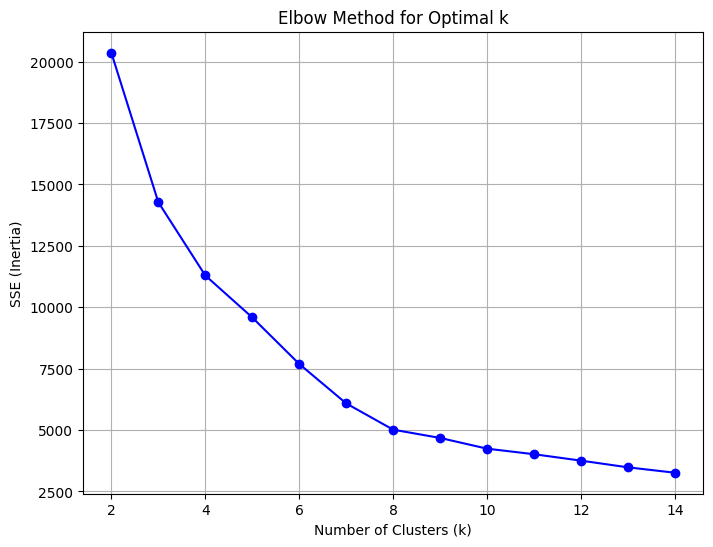

In [202]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(k, sse, 'bo-')  # Blue line with circles
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [203]:
# Your full select_features (cleaned array)
sil_scores = []
k_range = range(2, 15)  # Start at 2
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(select_features)
    labels = kmeans.labels_  # Use .labels_ post-fit
    score = silhouette_score(select_features, labels)
    sil_scores.append(score)
    print(k,score)


2 0.26212130860524596
3 0.2966086268309221
4 0.341816568330702
5 0.3648732772202913
6 0.4036141627899486
7 0.48368636951489286
8 0.5209311966113805
9 0.5203590154710712
10 0.5087735529537412
11 0.5095457021770167
12 0.5155596990450534
13 0.5177367438732082
14 0.5239259953324693


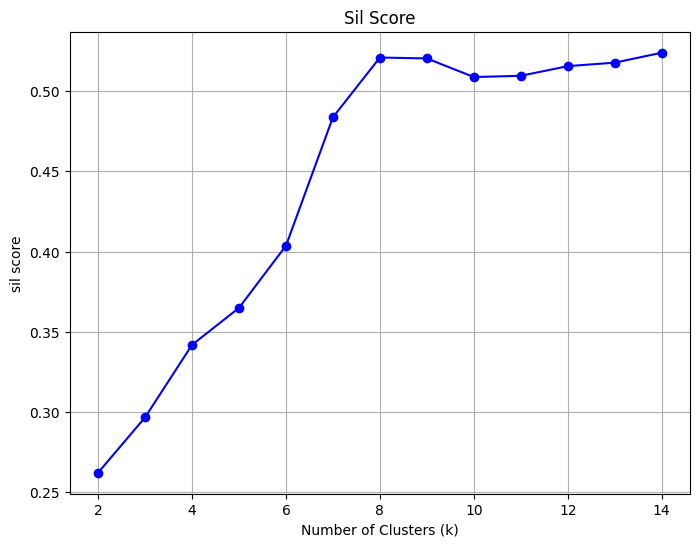

In [204]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(k_range, sil_scores, 'bo-')  # Blue line with circles
plt.xlabel('Number of Clusters (k)')
plt.ylabel('sil score')
plt.title('Sil Score')
plt.grid(True)
plt.show()

In [205]:
segments = KMeans(n_clusters = 8, n_init='auto', random_state=42)
segments.fit(select_features)

,n_clusters,8
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [206]:
carrier_data["labels"] = segments.labels_

In [207]:
carrier_data.head()

,carrier_number_name,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio,labels
2829,CR-292-B-ZIM,14,0.428571,0.571429,6,0.428571,2
4001,CR-685-C-Zim,14,0.642857,0.500000,6,0.428571,2
3164,CR-405-B-Zim,13,0.615385,0.615385,0,0.000000,6
4573,CR-878-B-ZIM,13,0.538462,0.692308,6,0.461538,2
4414,CR-825-A-ZIM,13,0.538462,0.692308,1,0.076923,6


In [208]:
carrier_data['ncm_ratio']= np.where(np.isinf(carrier_data['ncm_ratio']),0,carrier_data['ncm_ratio'])
carrier_data.head()

,carrier_number_name,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio,labels
2829,CR-292-B-ZIM,14,0.428571,0.571429,6,0.428571,2
4001,CR-685-C-Zim,14,0.642857,0.500000,6,0.428571,2
3164,CR-405-B-Zim,13,0.615385,0.615385,0,0.000000,6
4573,CR-878-B-ZIM,13,0.538462,0.692308,6,0.461538,2
4414,CR-825-A-ZIM,13,0.538462,0.692308,1,0.076923,6


<Axes: xlabel='labels'>

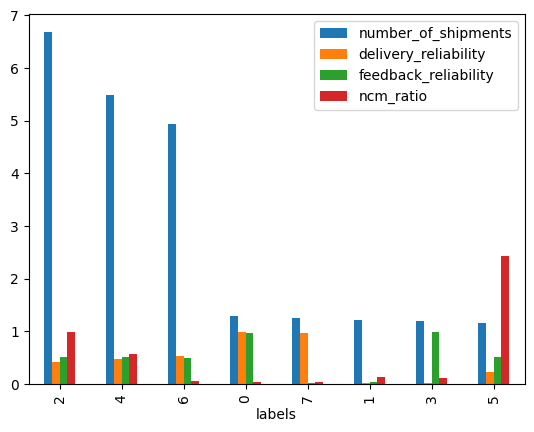

In [209]:
carrier_data.groupby('labels').agg({'number_of_shipments':'mean',
                                    'delivery_reliability':'mean',
                                    "feedback_reliability":'mean',
                                    'ncm_ratio': 'mean'}).sort_values(by='number_of_shipments',ascending=False).plot(kind='bar')

In [210]:
carrier_data.groupby('labels').agg({'number_of_shipments':'mean',
                                    'delivery_reliability':'mean',
                                    "feedback_reliability":'mean',
                                    'ncm_ratio': 'mean'}).sort_values(by='number_of_shipments',ascending=False)

,number_of_shipments,delivery_reliability,feedback_reliability,ncm_ratio
labels,,,,
2,6.685185,0.410676,0.501153,0.980818
4,5.477556,0.466377,0.500980,0.559661
6,4.930796,0.528430,0.494814,0.056737
0,1.282640,0.975849,0.965208,0.029770
7,1.246224,0.972180,0.011329,0.034995
1,1.216998,0.011453,0.034509,0.128692
3,1.185383,0.009210,0.989008,0.110368
5,1.146341,0.221254,0.504646,2.418699
